# Look into Tau TSSP

I explore using tau to calculate a gene level score indicating tissue specificity of a gene.

In [138]:
# %load start.py
# Imports
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from goatools.obo_parser import GODag
from goatools import GOEnrichmentStudy
from goatools.mapslim import mapslim

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb

# Setup notebook
nbconfig = Nb.setup_notebook('2018-02-05_tau', table_dir='../output')

last updated: 2018-02-05 
Git hash: 1443353a7467de312d944befa918997988f803db


In [98]:
# import GO dags
obodag = GODag("../data/external/go-basic.obo")
slimdag = GODag("../data/external/goslim_generic.obo")

load obo file ../data/external/go-basic.obo
../data/external/go-basic.obo: fmt(1.2) rel(2018-02-02) 47,109 GO Terms
load obo file ../data/external/goslim_generic.obo
../data/external/goslim_generic.obo: fmt(1.2) rel(None) 228 GO Terms


In [118]:
# Import fly associations
fly = defaultdict(set)
with open('../data/external/gene_association.fb') as fh:
    for row in fh.readlines():
        if row.startswith('!'):
            continue
        cols = row.split('\t')
        fbgn = cols[1]
        goterm = cols[4]
        gtype = cols[11]
        if gtype != 'protein':
            continue
        if goterm not in obodag:
            continue
        fly[fbgn].add(goterm)

In [121]:
# map them to a slim set
flyslim = defaultdict(set)
for fbgn, goterms in fly.items():
    all_direct_anc = set()
    all_covered_anc = set()
    all_all_anc = set()
    for goterm in goterms:
        direct_anc, all_anc = mapslim(goterm, obodag, slimdag)
        all_all_anc |= all_anc
        # collect all covered ancestors, so the direct ancestors
        # can be calculated afterwards
        all_covered_anc |= (all_anc - direct_anc)
    all_direct_anc = all_all_anc - all_covered_anc
    flyslim[fbgn] |= (all_direct_anc)

In [3]:
!cat ../data/external/haiwang/README

This data was provided by Haiwang on February 2, 2018. It consists of a
normalized counts matrix for D. melanogaster (w1118 and oreR). With the
following body parts:

ac --- abdomen carcass
dg --- digestive system
ge --- genitalia or terminalia
go --- gonad
hd --- head.
re --- reproductive tract
tx --- thorax
wb --- whole body.

This data is for use in calculating tau and TSPS.


In [4]:
# Import data and melt
dat = pd.read_csv('../data/external/haiwang/dmel.genic.nrc.txt', sep='\t')
dat.index.name = 'FBgn'

melted = dat.reset_index().melt(id_vars='FBgn', var_name='sample')

# Create metadata based on sample names
melted['strain'] = melted['sample'].map(lambda x: x.split('_')[0])
melted['sex'] = melted['sample'].map(lambda x: x.split('_')[1])
melted['tissue'] = melted['sample'].map(lambda x: x.split('_')[2])
melted['rep'] = melted['sample'].map(lambda x: x.split('_')[3])

# Calculate median across replicates
cleaned = melted.groupby(['FBgn', 'sex', 'tissue'])['value'].median().to_frame().unstack()

## tau

In [5]:
def tau(x):
    _max = x.max()
    if _max == 0:
        return np.nan
    _n = x.shape[0]
    xhat = x / _max
    tau = (1 - xhat).sum() / (_n - 1)
    return tau

In [6]:
# Calculate tau for each sex
taus = cleaned.apply(tau, axis=1).to_frame()
taus.columns = ['tau', ]

male_tau = taus.loc[(slice(None), 'm'), :]
female_tau = taus.loc[(slice(None), 'f'), :]

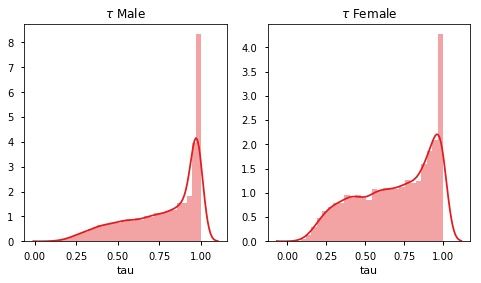

In [7]:
# Plot

def _plot():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(.5)) 
    sns.distplot(male_tau['tau'].dropna(), ax=ax1)
    ax1.set_title(r'$\tau$ Male')
    sns.distplot(female_tau['tau'].dropna(), ax=ax2)
    ax2.set_title(r'$\tau$ Female')

_plot()

In [83]:
# bg = male_tau.dropna().index.get_level_values(0).tolist()
# 
# goeaobj = GOEnrichmentStudy(
#         bg, # Background 
#         flyslim, # geneid/GO associations
#         slimdag, # Ontologies
#         propagate_counts = False,
#         alpha = 0.001, # default significance cut-off
#         methods = ['fdr_bh']) # defult multipletest correction method
# 
# bins = pd.qcut(male_tau.dropna().tau, 20).reset_index().set_index('tau')['FBgn']
# groups = {}
# for g, d in bins.to_frame().groupby(level=0):
#     try:
#         groups[g] = [r.name for r in goeaobj.run_study(d.FBgn.values.tolist(), log=None) if r.p_fdr_bh <= 0.001]
#     except ZeroDivisionError:
#         print(d)

In [157]:
male_tau.reset_index().set_index('FBgn').drop('sex', axis=1).to_csv(nbconfig.table_name('male_tau.tsv'), sep='\t')
female_tau.reset_index().set_index('FBgn').drop('sex', axis=1).to_csv(nbconfig.table_name('female_tau.tsv'), sep='\t')

## TSPS 

In [159]:
def tsps(x):
    from scipy.stats import entropy
    if x.sum() == 0:
        return np.nan
    _n = x.shape[0]
    _q = np.array([1 / _n, ] * _n)
    return entropy(x, _q, 2)

In [160]:
tspss = cleaned.apply(tsps, axis=1).to_frame()
tspss.columns = ['tsps', ]
male_tsps = tspss.loc[(slice(None), 'm'), :]
female_tsps = tspss.loc[(slice(None), 'f'), :]

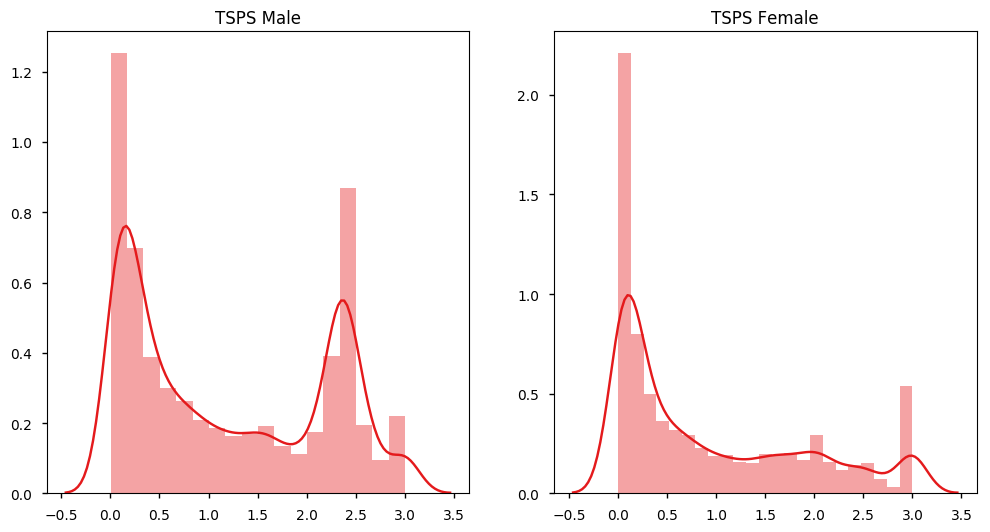

In [161]:
def _plot():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(.5))
    sns.distplot(male_tsps.dropna(), ax=ax1)
    ax1.set_title('TSPS Male')
    sns.distplot(female_tsps.dropna(), ax=ax2)
    ax2.set_title('TSPS Female')
    
_plot()

In [162]:
male_tsps.reset_index().set_index('FBgn').drop('sex', axis=1).to_csv(nbconfig.table_name('male_tsps.tsv'), sep='\t')
female_tsps.reset_index().set_index('FBgn').drop('sex', axis=1).to_csv(nbconfig.table_name('female_tsps.tsv'), sep='\t')